In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Gradient Tool #
We start by loading all the packages we're going to need…

In [2]:
import re

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs

import gradienttool as gt
import shared as ip2

from gradienttool.__main__ import normaliseArray

OK, that's the setup done.

Now we load our data from the disk and get it into a format suitable for analysis.

In [3]:
# read from disk
inp = ip2.readCsvNamedMatrix(open("gradienttool/testdata/demData.csv"))

# strip out TP from column names, convert to array and normalise so time runs from $0…1$
time = [re.sub('^TP','',x) for x in inp.colnames]
time = np.asarray(time, dtype=np.float64)

xtrans = (min(time), max(time)-min(time))
ytrans = (np.mean(inp.data), np.std(inp.data))

time = (time - xtrans[0]) / xtrans[1]

Now shove the data into Gradient Tool and run everything…

In [4]:
# which row of data are we working with
index = 0

# put the data into our Gradient Tool
g = gt.GradientTool(time, (inp.data[index,:] - ytrans[0]) / ytrans[1])

# Set Priors on Hyperparameters
g.setPriorRbfLengthscale(2.0, 0.2)
g.setPriorRbfVariance(2.0, 0.5)
g.setPriorNoiseVariance(1.5, 0.1)

# Optimise Hyperparameters
g.optimize()

Analysis complete, lets see the results…

         mu       var       mud      vard    tscore
1  0.023444  0.008545  0.310038  0.003636  5.141337
2  0.327468  0.004048  0.293755  0.001819  6.887314
3  0.602551  0.003145  0.252358  0.000851  8.653211
4  0.824647  0.003122  0.188438  0.000476  8.635602
5  0.973622  0.003039  0.107175  0.000398  5.371723


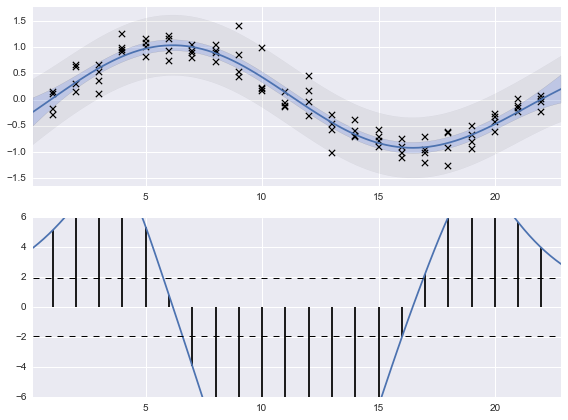

In [5]:
CI = sp.stats.norm.ppf([0.025,0.975])

res  = g.getResults()
ar = ip2.niceAxisRange(res.index)
res2 = g.getResults(np.linspace(ar[0],ar[1],101))

# transform back to unnormalised space
res  = gt.transformResults(res,  xtrans, ytrans)
res2 = gt.transformResults(res2, xtrans, ytrans)

print(res.head())

# extract for ease of access
mu     = res2['mu']
var    = res2['var']
mud    = res2['mud']
tscore = res['tscore']

# set up plots
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
fig.tight_layout()

ax1.margins(0.04)
ax2.set_ylim([-6,6])

# draw data, function and error bars
ax1.fill_between(mu.index,
                 mu + CI[0]*np.sqrt(var + g.noiseVariance),
                 mu + CI[1]*np.sqrt(var + g.noiseVariance),
                facecolor='black', alpha=0.05)
ax1.fill_between(mu.index,
                 mu + CI[0]*np.sqrt(var),
                 mu + CI[1]*np.sqrt(var),
                facecolor='royalblue', alpha=0.2)
mu.plot(ax=ax1)
# data goes at the end so it doesn't get hidden by everything else
ax1.scatter(g.X * xtrans[1] + xtrans[0],
            g.Y * ytrans[1] + ytrans[0],
            marker='x', c='black', s=40, lw=1.2);

# draw t-scores
ax2.vlines(tscore.index, 0, tscore)
ax2.plot(res2.index, res2['tscore'])
for y in CI:
    ax2.axhline(y, lw=1, ls='--', color='black')

# ax2.plot(gt.zerosLinearInterpolate(np.vstack([mud.index, mud]).T), [0,0],'*')